In [1]:
# Image Classification Using Pre-Trained models

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.12.0


In [3]:
# Dataset downloading
URL_path = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL_path, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 4s 0us/step


In [4]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [6]:
# train dataset
train_dataset = image_dataset_from_directory(os.path.join(PATH, 'train'),
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [7]:
# validation dataset
validation_dataset = image_dataset_from_directory(os.path.join(PATH, 'validation'),
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [8]:
datapoint = train_dataset.take(1)
datapoint

<_TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
for image, label in datapoint:
  print(image.numpy().shape)
  print(label.numpy())
  break

(32, 160, 160, 3)
[0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0]


In [10]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

In [11]:
# visualize image dataset
def visualize_dataset(datapoint):
  plt.figure(figsize=(10, 10))
  for images, labels in datapoint:
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

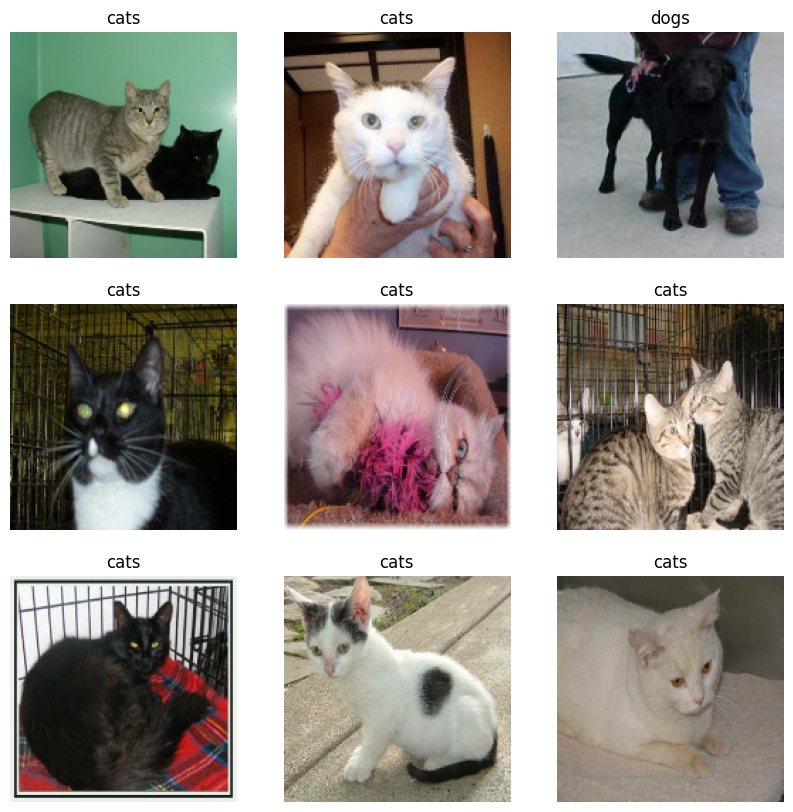

In [12]:
visualize_dataset(datapoint)

In [13]:
# Create Test dataset from validation dataset batches
validation_batch_count = tf.data.experimental.cardinality(validation_dataset)

test_dataset = validation_dataset.take(validation_batch_count // 5) # take 20% data from validation
validation_dataset = validation_dataset.skip(validation_batch_count // 5) # keep remaining data
validation_batch_count.numpy()

32

In [14]:
# Function to load images and apply image augmentation on training dataset

@tf.function
def load_image_train(image, label):
  # Preprocessing layer

  input_image = tf.image.resize(image, (160, 160))


  # Image Augmentation layers : random flip
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_image = tf.image.flip_up_down(input_image)

  return input_image, label

In [15]:
# No augmentation is not needed for test dataset

def load_image_test(image, label):
  input_image = tf.image.resize(image, (160, 160))

  return input_image, label

In [16]:
# Setting Hyperparameters
TRAIN_LEN = 2000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LEN // BATCH_SIZE

In [17]:
# creating Input pipeline for distributed training

train_ds = (
    train_dataset
    .map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .cache()
    .repeat()
    .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    )

validation_ds = (
    validation_dataset
    .map(load_image_test)
    .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
)

test_ds = (
    test_dataset
    .map(load_image_test)
    .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
)

In [18]:
# Setting number of output channels : number of classes = 2
OUTPUT_CHANNELS = 1

In [19]:
for image, label in train_ds.take(1):
  print(image.numpy().shape)
  print(label.numpy())
  break

(32, 160, 160, 3)
[0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1]


In [20]:
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

(160, 160, 3)

In [21]:
# base model of MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=[160, 160, 3],
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [22]:
# setting the trainable parameter of pre-trained model to False
base_model.trainable = False

In [ ]:
"""
It is important to freeze the convolutional base before you compile and train the model.
Freezing (by setting layer.trainable = False) prevents the weights in a given layer
from being updated during training. MobileNet V2 has many layers, so setting the
 entire model's trainable flag to False will freeze all of them.
 """

"""
 Many models contain tf.keras.layers.BatchNormalization layers.
 This layer is a special case and precautions should be taken in the context
 of fine-tuning, as shown later in this tutorial.

 When you set layer.trainable = False, the BatchNormalization layer will run
  in inference mode, and will not update its mean and variance statistics.

 When you unfreeze a model that contains BatchNormalization layers in order to
 do fine-tuning, you should keep the BatchNormalization layers in inference mode
  by passing training = False when calling the base model. Otherwise, the updates
   applied to the non-trainable weights will destroy what the model has learned.

"""
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.

In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:

# MobileNet V2:
"""
MobileNetV2 is a convolutional neural network architecture designed for efficient
 and lightweight deep learning tasks. It's particularly useful for mobile and
 embedded applications due to its compact design while maintaining respectable
 accuracy. The architecture contains multiple layers, including depthwise
 separable convolutions, that allow it to achieve a good trade-off between model
  size and performance.
  """

#Feature Extraction:
"""
Feature extraction involves using a pre-trained deep learning model to capture
meaningful features from input data. Instead of training the entire model from
scratch, you leverage the knowledge already acquired by the model during its
 original training on a large dataset.
 """


#Bottleneck Layer:
"""
The "bottleneck layer" refers to the last convolutional layer before the final
classification layers in the MobileNet V2 architecture. This layer is called a
"bottleneck" because it represents a condensed version of the feature map before
it's flattened and passed to the fully connected layers for classification.
The features in this layer are more general and abstract compared to the final
classification layer, making them useful for various tasks beyond the specific
 classes in ImageNet.
"""

#Include Top Argument:
"""
When you instantiate a MobileNet V2 model using a deep learning framework like
Keras, you have the option to specify the include_top argument.
 By setting include_top=False, you're indicating that you want to exclude
 the final classification layers from the model. This is commonly done when using
 the model for feature extraction, as you're interested in the intermediate
 features rather than the final classification.
 """

In [27]:
# try model feature extraction on 1 batch of dataset
for img, label in train_ds.take(1):
  image_batch, label_batch = img, label
  break
image_batch.shape

TensorShape([32, 160, 160, 3])

In [28]:
# Do feature extraction using base_model
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 1280])

In [29]:
# Global average pooling operation for spatial data.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

In [ ]:
# prediction layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.numpy()

In [31]:
# build the last classification layer
# ImageNet Classification model

def image_classification_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[160, 160, 3])

  preprocess_layer = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

  model_layer = base_model(inputs, training = False)

  avg_pool_layer = tf.keras.layers.GlobalAveragePooling2D()(model_layer)

  dropout_layer = tf.keras.layers.Dropout(0.2)(avg_pool_layer)

  output = tf.keras.layers.Dense(output_channels)(dropout_layer)

  return tf.keras.Model(inputs=inputs, outputs=output)


In [32]:
# create model
model = image_classification_model(OUTPUT_CHANNELS)

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable

In [35]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 47ms/step - loss: 0.8467 - accuracy: 0.4963


In [36]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.50


In [37]:
model_history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 8s 63ms/step - loss: 0.8065 - accuracy: 0.5150 - val_loss: 0.7144 - val_accuracy: 0.5495
Epoch 2/10
63/63 [==============================] - 4s 56ms/step - loss: 0.7535 - accuracy: 0.5595 - val_loss: 0.6800 - val_accuracy: 0.5866
Epoch 3/10
63/63 [==============================] - 4s 55ms/step - loss: 0.7233 - accuracy: 0.5710 - val_loss: 0.6554 - val_accuracy: 0.6176
Epoch 4/10
63/63 [==============================] - 5s 72ms/step - loss: 0.6867 - accuracy: 0.5820 - val_loss: 0.6366 - val_accuracy: 0.6312
Epoch 5/10
63/63 [==============================] - 4s 57ms/step - loss: 0.6768 - accuracy: 0.6030 - val_loss: 0.6164 - val_accuracy: 0.6510
Epoch 6/10
63/63 [==============================] - 4s 56ms/step - loss: 0.6511 - accuracy: 0.6350 - val_loss: 0.6107 - val_accuracy: 0.6535
Epoch 7/10
63/63 [==============================] - 4s 55ms/step - loss: 0.6395 - accuracy: 0.6265 - val_loss: 0.5966 - val_accuracy: 0.6510
Epoch 8/10
63

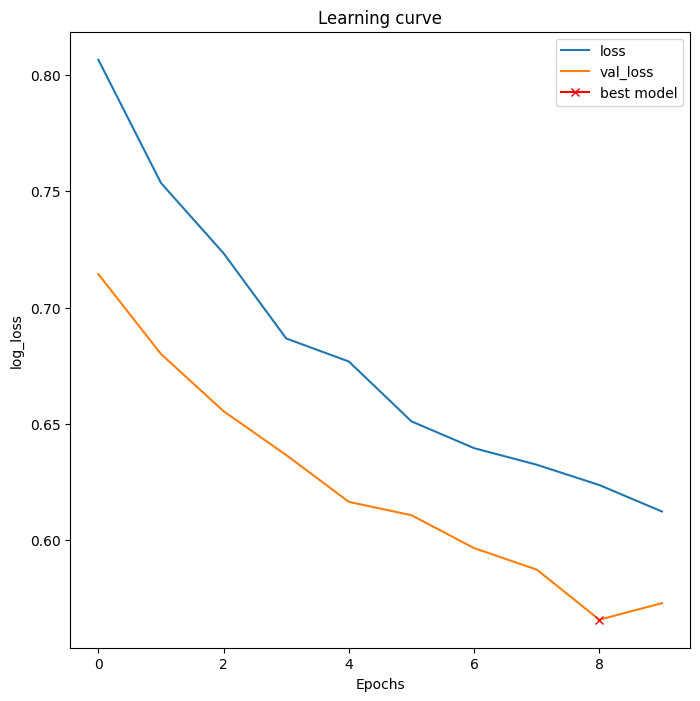

In [38]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plotting Loss per epochs for model learning
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_history.history["loss"], label="loss")
plt.plot(model_history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

Predictions:
 [0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1]
Labels:
 tf.Tensor([0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1], shape=(32,), dtype=int32)


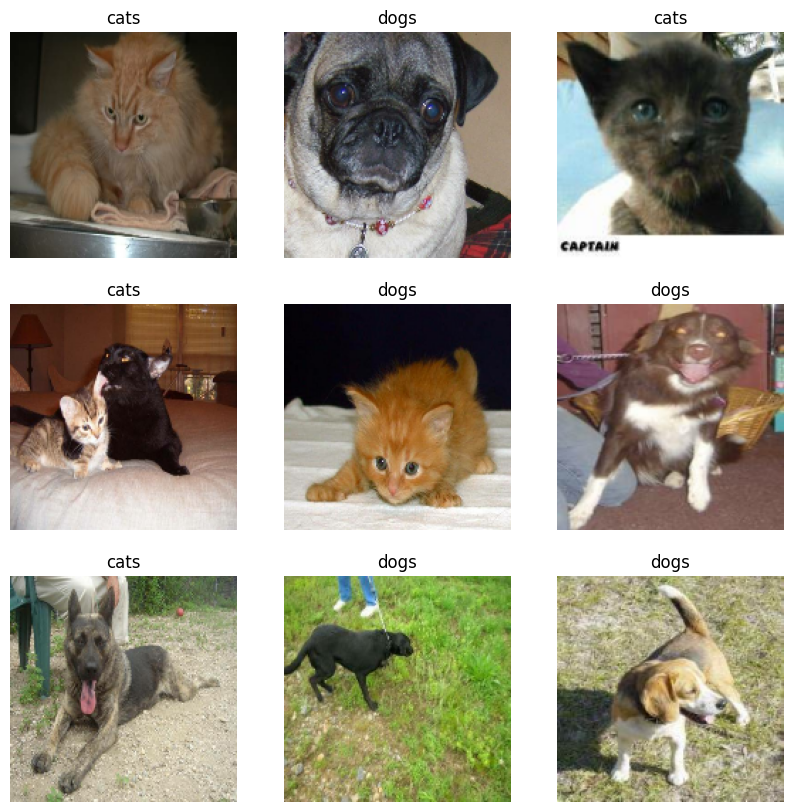

In [77]:
#Retrieve a batch of images from the test set
for img, label in test_dataset.take(1):
  image_batch, label_batch = img, label

predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
# TODO
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
